In [1]:
import pandas as pd
import numpy as np
from snowflake.sqlalchemy import URL

/Users/keyurpethad/anaconda3/lib/python3.11/site-packages/snowflake/connector/options.py:103: UserWarning: You have an incompatible version of 'pyarrow' installed (11.0.0), please install a version that adheres to: 'pyarrow<10.1.0,>=10.0.1; extra == "pandas"'
  warn_incompatible_dep(


In [2]:
from sqlalchemy import create_engine


class extractorFromQuery:
    def __init__(self):
        self.credentials = {
            "account": "qfi-niro",
            "user": "keyur",
            "password": "Keyur@17061996",
            "warehouse": "NIRO_ANALYTICS_WAREHOUSE",
        }

    def queryExecutor(self, query: str, *args):
        engine = create_engine(URL(**self.credentials))
        res = pd.read_sql_query(query, engine, params=args)
        return res

In [3]:
df_data_with_cvattrs = """
select * from (
            select 
            distinct la.id,
            CASE 
            WHEN upper(la.rejection_reason) LIKE 'PAYU%' THEN 'PAYU CHECK-ELIGIBILITY FAILED'
            WHEN upper(la.rejection_reason) LIKE 'INTERNAL BRE REJECTED%' THEN 'INTERNAL BRE REJECTED'
            WHEN upper(la.rejection_reason) LIKE 'INCORRECT INFO%' THEN 'INCORRECT INFORMATION'
            WHEN upper(la.rejection_reason) LIKE 'LOW/NO INCOME PROOF%' THEN 'LOW/NO INCOME PROOF'
            WHEN upper(la.rejection_reason) LIKE 'NO RESPONSE%' THEN 'NO RESPONSE'
            WHEN upper(la.rejection_reason) LIKE 'CUST REQUESTED CANCELLATION%'
            OR upper(la.rejection_reason) LIKE 'CUSTOMER REQUESTED%'
            OR upper(la.rejection_reason) LIKE 'CX REQUESTED TO CANCEL%'
            OR upper(la.rejection_reason) LIKE 'CX RQUESTED%'
            THEN 'CUSTOMER REQUESTED CANCELLATION'
            WHEN upper(la.rejection_reason) LIKE 'TOO MANY /RECENT BOUNCES%' 
            OR upper(la.rejection_reason) LIKE 'TOO MANY BOUNCES/RECENT BOUNCES%'
            THEN 'TOO MANY BOUNCES/RECENT BOUNCES'
            ELSE la.rejection_reason
            END as rejection_reason_grouped,
            CASE WHEN la.loan_application_status = 'REJECTED' THEN 'REJECTED'
            WHEN la.loan_application_status in ('CLOSED', 'LOAN_EXECUTED') THEN 'DISBURSED'
            END as loan_status,
            CASE WHEN la.loan_application_status = 'REJECTED' THEN date(la.rejected_at)
            WHEN la.loan_application_status in ('CLOSED', 'LOAN_EXECUTED') THEN 
                CASE
                    WHEN la.loan_disbursed_date_by_ops is null then date(la.disbursement_date)
                    ELSE date(la.loan_disbursed_date_by_ops)
                END
            END as credit_date,
            la.rejection_reason,
            la.rejected_at_stage,
            pii.gender as cibil_gender,
            pii.pin as cibil_pincode,
            pii.calculated_age,
            pii.city as cibil_city,
            pii.state as cibil_state,
            pii.native_language,
            tli.*,
            date_trunc("MONTH",date(od.created_at)) as createdate,
            o.attributed_partner,
            od.current_salary,
            od.available_income,
            od.foir_dlq, od.foir_cibil, od.foir_trd, od.foir_mean, od.new_foir, 
            od.naps_score,
            ou.category,
            l.name as lender,
            rank()over(partition by od.user_id order by od.created_at desc) as rnk
            from NIRO_RDS.NIRO_DATA.CORE__PUBLIC__LOAN_APPLICATION la
            left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__OFFERS o on o.id = la.offer_id
            left join NIRO_RDS.NIRO_DATA.core__public__offer_user_details ou on ou.user_id = la.user_id
            left join ANALYTICS.OFFERS.offer_details od on od.user_id = la.user_id
            left join ANALYTICS.OFFERS.personal_info pii on od.pii_id = pii.pii_id
            left join ANALYTICS.OFFERS.tradeline_info tli on tli.tli_id = od.tli_id
            left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__LENDERS l on l.id = o.lender_uid
            left join NIRO_RDS.NIRO_DATA.CORE__PUBLIC__NACH_DETAILS nd on la.nach_id = nd.id
            where la.loan_application_status in ('REJECTED', 'CLOSED', 'LOAN_EXECUTED')
            and (((la.rejected_at >= '2023-10-01') and (la.rejected_at < '2024-02-14')) or ((la.loan_disbursed_date_by_ops >= '2023-10-01') and (la.loan_disbursed_date_by_ops < '2024-02-14')) or ((la.disbursement_date >= '2023-10-01') and (la.disbursement_date < '2024-02-14')))
            and nd.nach_status in ('AUTH_SUCCESS', 'REG_SUCCESS')
            )
where rnk = 1;
"""

df_data = (
    extractorFromQuery()
    .queryExecutor(df_data_with_cvattrs)
)
df_data.shape

(32205, 97)

In [4]:
df_data = df_data.drop_duplicates(subset=["id"])

In [5]:
df_data['credit_date'] = pd.to_datetime(df_data['credit_date'], format='%d-%m-%Y', utc=True)
df_data['credit_month'] = df_data['credit_date'].dt.strftime('%Y%m')

In [6]:
df_data.groupby('credit_month')['loan_status'].value_counts()

credit_month  loan_status
202310        REJECTED       3799
              DISBURSED      3416
202311        REJECTED       3437
              DISBURSED      2773
202312        REJECTED       3904
              DISBURSED      3391
202401        DISBURSED      3738
              REJECTED       3679
202402        REJECTED       1586
              DISBURSED      1108
Name: count, dtype: int64

In [7]:
df_data.groupby('credit_month')['loan_status'].value_counts(normalize=True)

credit_month  loan_status
202310        REJECTED       0.526542
              DISBURSED      0.473458
202311        REJECTED       0.553462
              DISBURSED      0.446538
202312        REJECTED       0.535161
              DISBURSED      0.464839
202401        DISBURSED      0.503977
              REJECTED       0.496023
202402        REJECTED       0.588716
              DISBURSED      0.411284
Name: proportion, dtype: float64

In [8]:
df_data.groupby(['credit_month', 'lender'])['loan_status'].value_counts(normalize=True)

credit_month  lender      loan_status
202310        liquiloans  DISBURSED      0.578915
                          REJECTED       0.421085
              muthoot     REJECTED       1.000000
              payu        REJECTED       0.555615
                          DISBURSED      0.444385
202311        liquiloans  DISBURSED      0.517026
                          REJECTED       0.482974
              muthoot     REJECTED       1.000000
              payu        REJECTED       0.574365
                          DISBURSED      0.425635
202312        liquiloans  DISBURSED      0.521759
                          REJECTED       0.478241
              payu        REJECTED       0.559468
                          DISBURSED      0.440532
202401        liquiloans  DISBURSED      0.512118
                          REJECTED       0.487882
              payu        REJECTED       0.501094
                          DISBURSED      0.498906
202402        liquiloans  REJECTED       0.603346
            

In [9]:
column_name_map = {'agg911': 'max_aggregate_bankcard_utilisation_l12m', 'rvlr01': 'cc_util_revolving_l1m', 'bcpmtstr': 'bank_card_payment_category', 'cv11': 'no_of_60p_accs_ever', 'cv14': 'no_of_deduped_inquiries', 
                   'mt28s': 'total_cl_open_mortgage_trades_l12m', 'mt33s': 'total_balance_open_mortgage_trades_l12m', 'pl33s':'total_bal_of_open_pl_l12m', 'at20s':'months_since_oldest_trade', 
                   'mt01s':'no_of_mortgage_trades', 'bc02s':'no_of_open_cc_trades', 'bg01s':'no_of_business_general_trades', 'cv10':'no_of_30p_accs_ever', 'trd':'no_of_trades', 'at33a':'total_bal_open_trades_l12m',
                   'au33s':'total_bal_open_auto_trades_l12m', 'co04s180':'months_since_recent_chargedoff180P', 'au28s':'total_cl_open_auto_trades_l12m', 'pl28s':'total_cl_open_pl_trades_l12m',
                   'co01s180':'no_of_chargedoff180P', 'bc28s':'total_cl_of_cc_trades_l12m', 'cv12':'no_of_90p_accs_ever', 'co05s':'total_bal_of_chargedoff_trades', 'g310s':'worst_rating_l12m',
                   'aggs911':'current_utilization_of_top_wallet_bankcard', 'at01s':'no_of_trades_pl_2w_gl_cd', 'at33a_ne_ccod':'total_bal_open_trades_l12m_except_wo_cc_od', 'cv14_12m':'no_of_deduped_inquiries_l12m',
                   'cv14_6m':'no_of_deduped_inquiries_l6m', 'cv14_3m':'no_of_deduped_inquiries_l3m', 'cv14_1m':'no_of_deduped_inquiries_l1m', 'g310s_24m':'worst_rating_l24m',
                   'g310s_6m':'worst_rating_l6m', 'g310s_3m':'worst_rating_l3m', 'g310s_1m':'worst_rating_l1m', 'cv11_24m':'no_of_60p_accs_l24m', 'cv11_12m':'no_of_60p_accs_l12m', 'g057s_1dpd_36m': 'no_of_trades_bounced_l36m',
                   'g057s_1dpd_12m':'no_of_trades_bounced_l12m', 'bc106s_60dpd':'no_of_cc_trades_60P_l24m', 'bc107s_24m':'no_of_30P_cc_l24m', 'bc106s_60dpd_12m':'no_of_cc_trades_60P_l12m', 'bc107s_12m':'no_of_30P_cc_l12m',
                   'bc106s_le_30dpd_12m':'no_of_cc_lt30p_l12m', 'bc09s_36m_hcsa_le_30':'no_cc_sanctionedamt_lt30K_l36m', 'pl09s_36m_hcsa_le_30':'no_pl_sanctionedamt_lt30K_l36m', 'at09s_6m':'no_tr_opened_l6m',
                   'g310s_36m':'worst_dpd_l36m', 'at33a_ne_wo':'total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades', 'at09s_12m':'no_tr_opened_l12m', 'at09s_3m':'no_tr_opened_l3m', 'cv13':'per_of_30p_accs_ever',
                    'cv24':'total_payment_amount_bankcard_accs_l3m', 'revs904':'max_revolving_monthly_spend_l12m', 'cv20':'total_monthly_obligations_l3m', 'cv22':'total_balance_bankcard_accs_l3m', 
                    'ul_trd':'no_of_trades_unsec', 'cv21':'total_payment_amount_l3m', 'g310s_2m':'worst_dpd_l2m'}

df_data.rename(columns = column_name_map, inplace=True)

In [10]:
df_data['event'] = df_data['loan_status'].replace({'DISBURSED':1, 'REJECTED':0})

#### Bucketing

In [11]:
from optbinning import BinningProcess

(CVXPY) Feb 15 08:00:14 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 15 08:00:14 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [12]:
df_train = df_data.copy()

In [13]:
cat_cols = [col for col in df_data.columns if (((df_data[col].dtype.kind not in 'bifc') or (len(np.unique(df_data[col]))<=2) and (col != 'event')))]

In [14]:
cat_cols

['id',
 'rejection_reason_grouped',
 'loan_status',
 'credit_date',
 'rejection_reason',
 'rejected_at_stage',
 'cibil_gender',
 'cibil_pincode',
 'cibil_city',
 'cibil_state',
 'native_language',
 'tli_id',
 'pii_id',
 'bank_card_payment_category',
 'months_since_recent_chargedoff180P',
 'no_of_chargedoff180P',
 'no_of_90p_accs_ever',
 'total_bal_of_chargedoff_trades',
 'no_of_60p_accs_l24m',
 'no_of_60p_accs_l12m',
 'total_bal_open_trades_l12m_minus_total_bal_of_chargedoff_trades',
 'own_accounts_count',
 'createdate',
 'attributed_partner',
 'category',
 'lender',
 'rnk',
 'credit_month']

In [15]:
df_train.drop(columns = cat_cols, inplace=True)

In [16]:
feature_list = df_train.drop(columns=['event']).columns.values
binning_process = BinningProcess(variable_names=feature_list, min_prebin_size = 0.01, max_n_bins=5, min_bin_size = 0.03, special_codes=[np.nan], max_pvalue = 0.35, max_pvalue_policy = "consecutive") # binning_fit_params = binning_fit_params,
binning_process.fit(df_train.drop(columns=['event']), df_train['event'])
df_train_binned = binning_process.transform(df_train.drop(columns=['event']), metric="bins")

In [17]:
feature_list_binned = [(str(x) + '_bkt') for x in df_train_binned.columns.values]

In [18]:
df_data = df_data[['event'] + cat_cols + list(df_train_binned.columns)]
df_data[feature_list_binned] = df_train_binned

In [19]:
df_data.head()

,event,id,rejection_reason_grouped,loan_status,credit_date,rejection_reason,rejected_at_stage,cibil_gender,cibil_pincode,cibil_city,...,other_accounts_count_bkt,bureau_score_bkt,current_salary_bkt,available_income_bkt,foir_dlq_bkt,foir_cibil_bkt,foir_trd_bkt,foir_mean_bkt,new_foir_bkt,naps_score_bkt
0,0,44017a43-a7e9-4bac-b0bf-e84bfb79a890,Liquiloans BRE check failed,REJECTED,2023-10-09 00:00:00+00:00,Liquiloans BRE check failed,ELIGIBILITY_CHECK_IN_PROGRESS,Female,251002,MUZAFFARNAGAR,...,"[4.50, 7.50)","[769.50, 786.50)","(-inf, 48561.12)","[23288.68, 26963.03)","(-inf, inf)","(-inf, 0.45)","[0.47, inf)","[0.47, inf)","[43.06, 65.01)","(-inf, 726.50)"
1,0,4ca72ebd-bdf4-4d66-80d2-89f0348429f4,Cust - No Response,REJECTED,2024-01-31 00:00:00+00:00,Cust - No Response,VERIFICATION,Female,700020,KOLKATA,...,"[2.50, 4.50)","[757.50, 769.50)",Missing,Missing,Missing,Missing,Missing,Missing,"(-inf, 38.24)","[726.50, 748.50)"
2,0,dc85c748-e4c2-478a-aff4-12eff29e7fba,Pincode Not Serviceable,REJECTED,2023-12-28 00:00:00+00:00,Pincode Not Serviceable,VERIFICATION,Female,421303,ULHASNAGAR,...,"[7.50, 13.50)","[757.50, 769.50)","[75137.62, 132307.94)","[28000.87, 102957.07)","(-inf, inf)","(-inf, 0.45)","(-inf, 0.42)","(-inf, 0.44)","[38.24, 43.06)","[748.50, 772.50)"
3,0,1c5ec90c-b602-4290-9b28-dbe3942e5395,CUSTOMER REQUESTED CANCELLATION,REJECTED,2023-11-16 00:00:00+00:00,Cust Requested Cancellation,VERIFICATION,Female,560100,BANGALORE,...,"[4.50, 7.50)","[738.50, 757.50)","[132307.94, 420034.78)","[102957.07, inf)","(-inf, inf)","(-inf, 0.45)","[0.42, 0.44)","[0.44, 0.44)","(-inf, 38.24)","[748.50, 772.50)"
4,0,3fb5d8b6-ee63-4ba8-9275-3a6d9b2624d8,Negative CPV,REJECTED,2023-11-06 00:00:00+00:00,Negative CPV,VERIFICATION,Male,560078,BANGALORE,...,"[7.50, 13.50)","[738.50, 757.50)","(-inf, 48561.12)","(-inf, 23288.68)","(-inf, inf)","(-inf, 0.45)","[0.44, 0.47)","[0.44, 0.47)","[80.32, inf)","[726.50, 748.50)"


#### Plotting

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

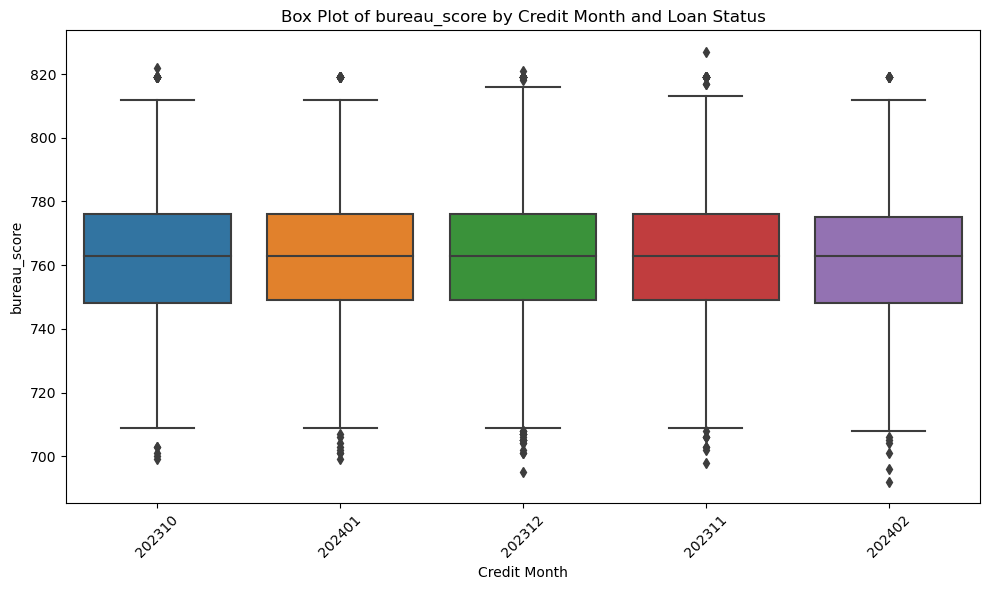

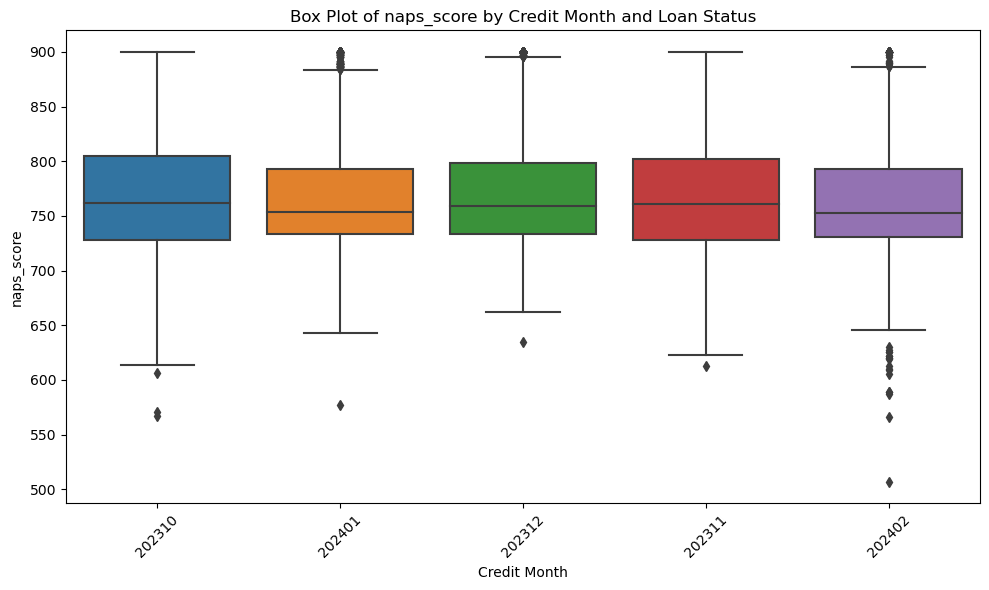

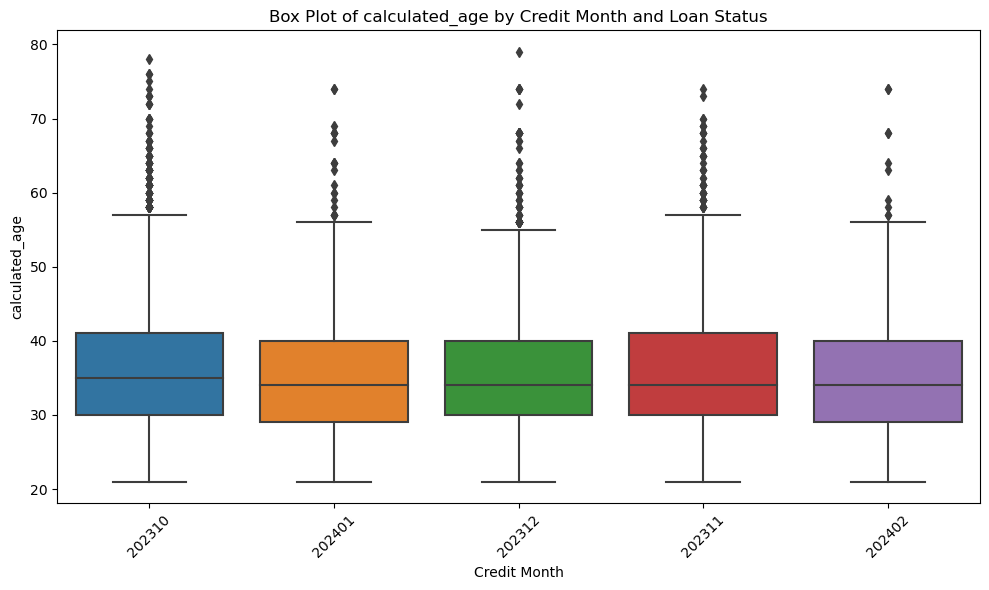

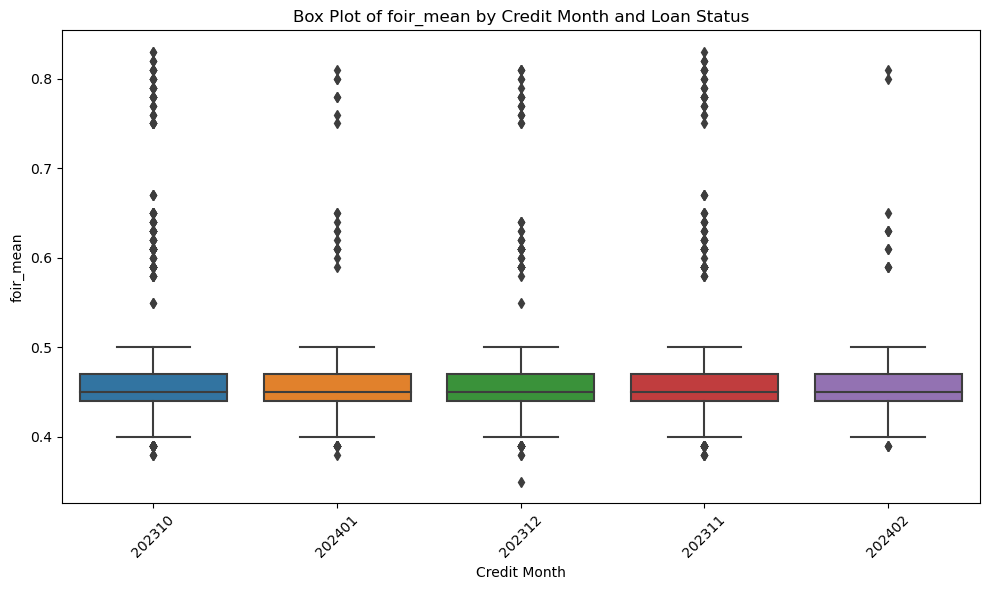

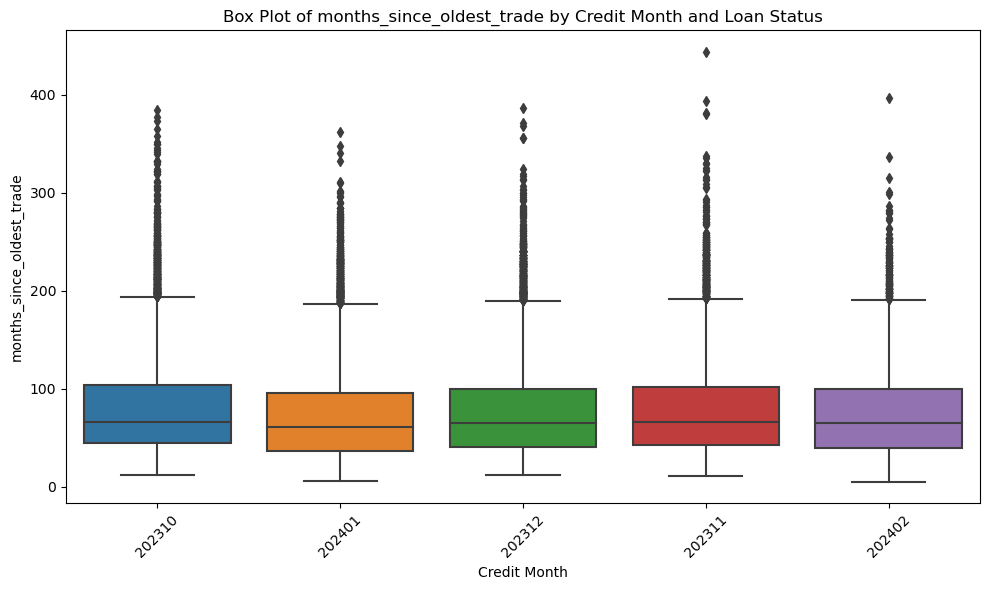

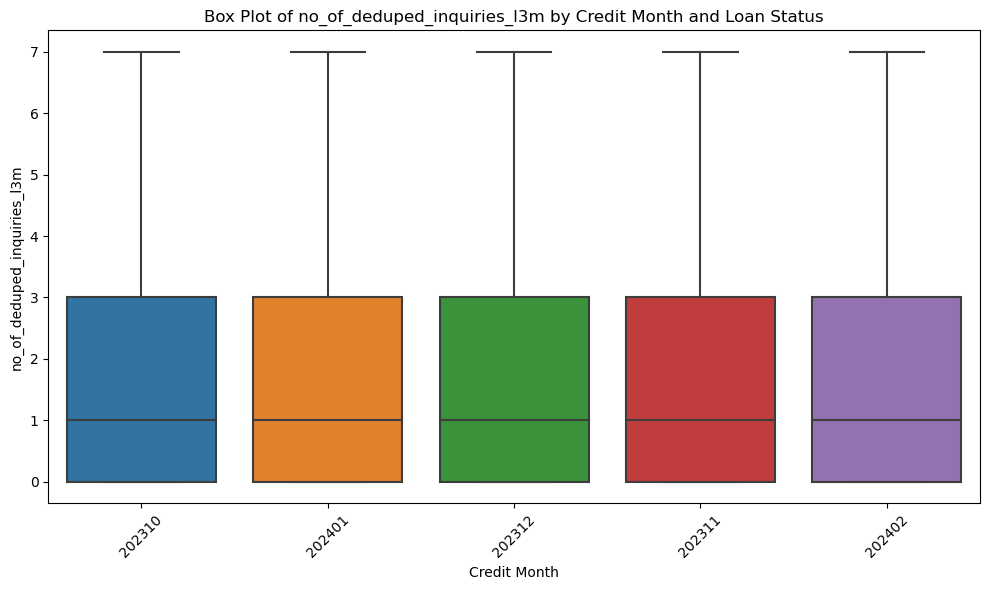

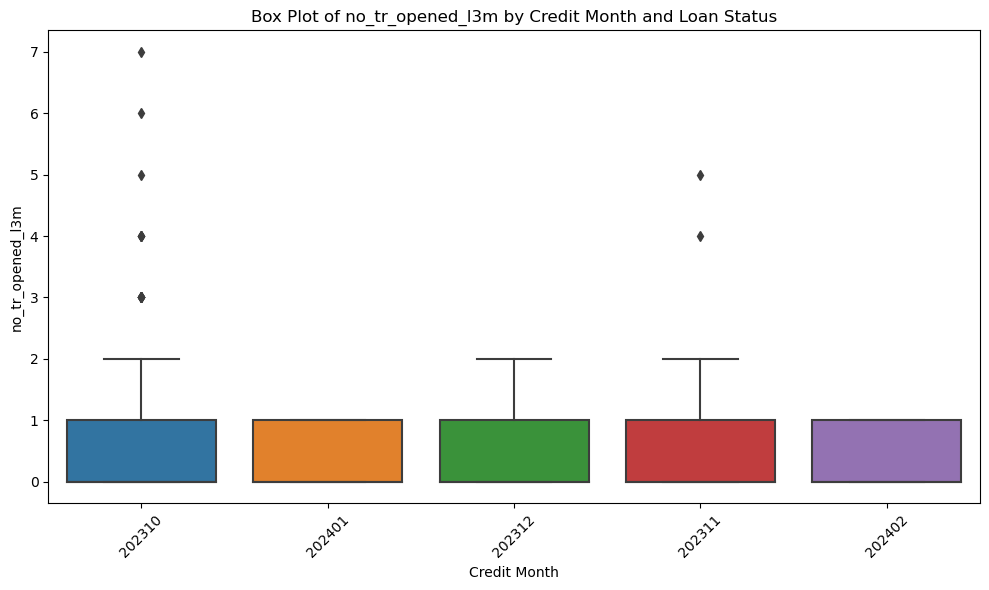

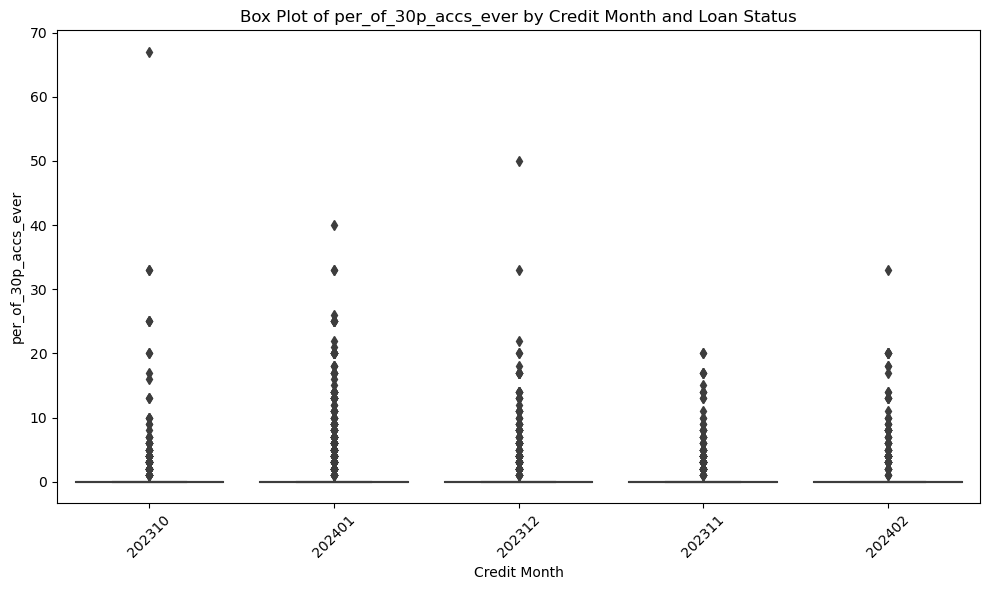

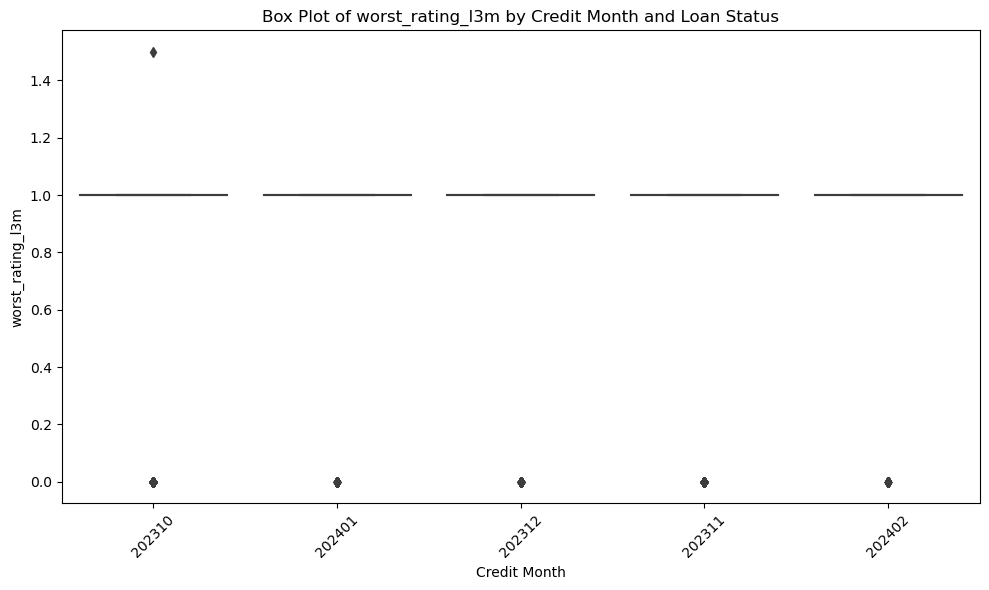

In [21]:
for field in ["bureau_score", "naps_score", "calculated_age", "foir_mean", "months_since_oldest_trade", "no_of_deduped_inquiries_l3m", "no_tr_opened_l3m", "per_of_30p_accs_ever", "worst_rating_l3m"]:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.boxplot(data=df_data, x="credit_month", y=field)
    plt.title(f"Box Plot of {field} by Credit Month and Loan Status")
    plt.xlabel("Credit Month")
    plt.ylabel(field)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

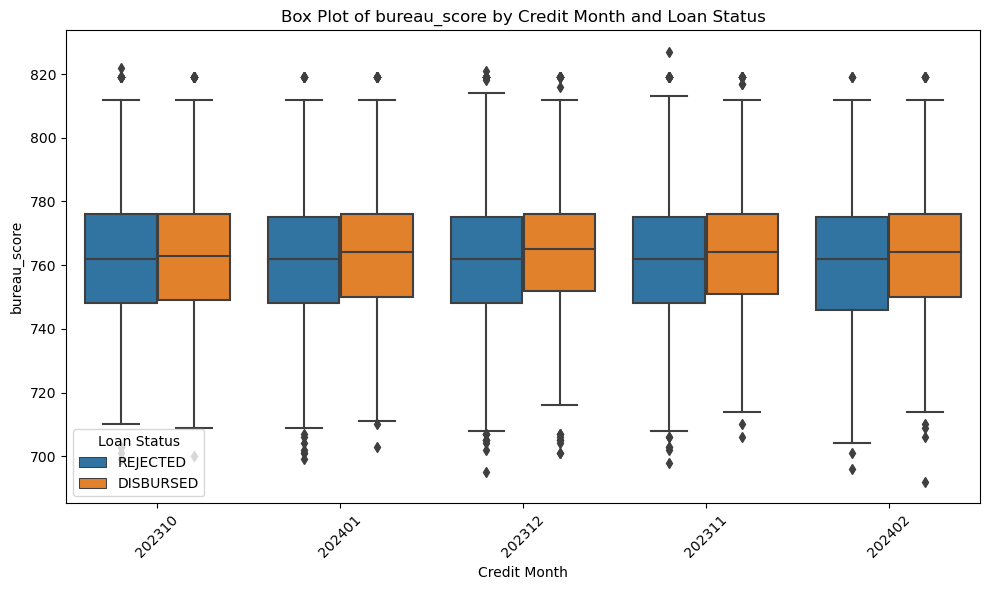

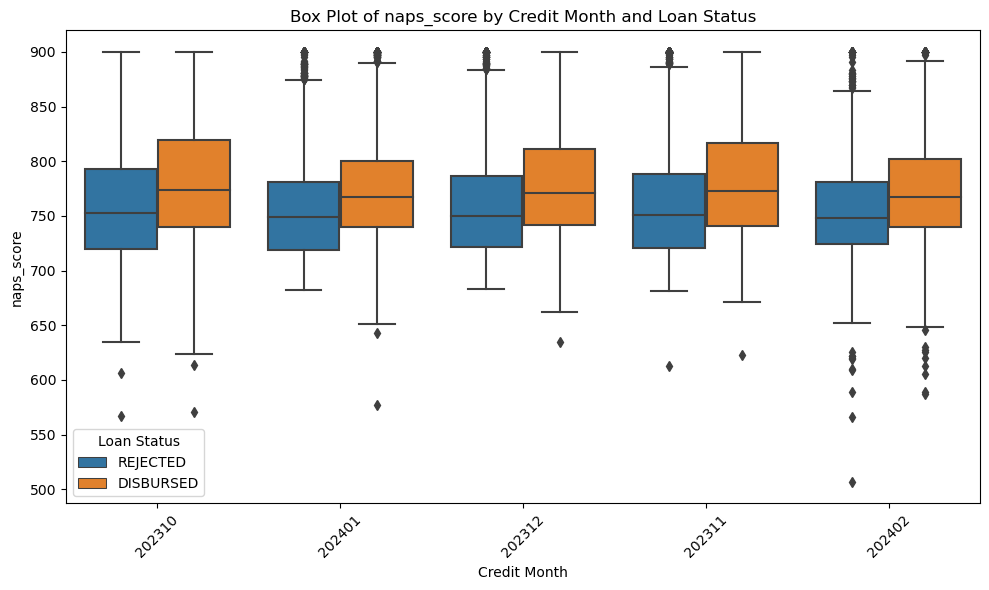

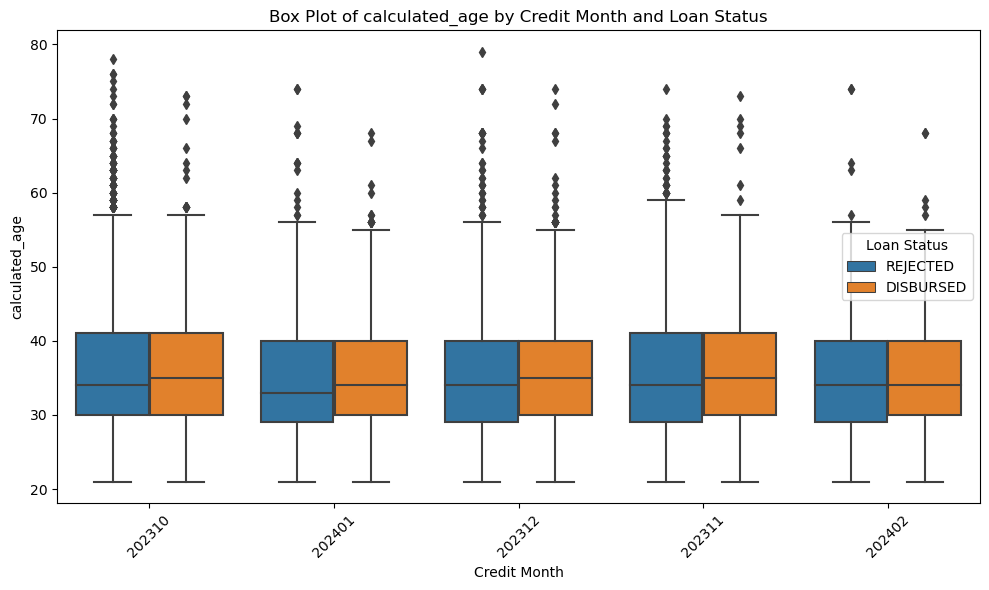

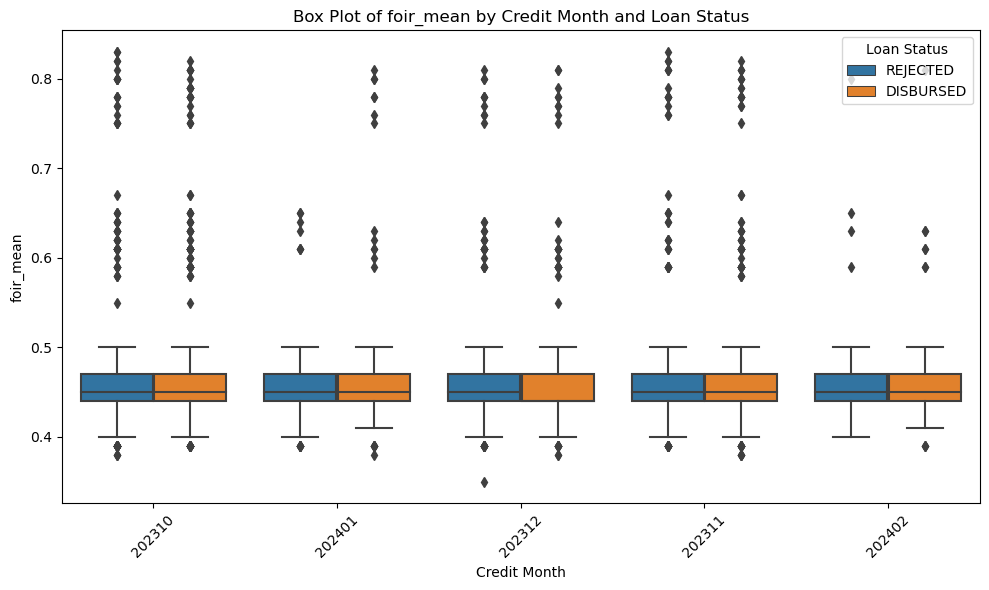

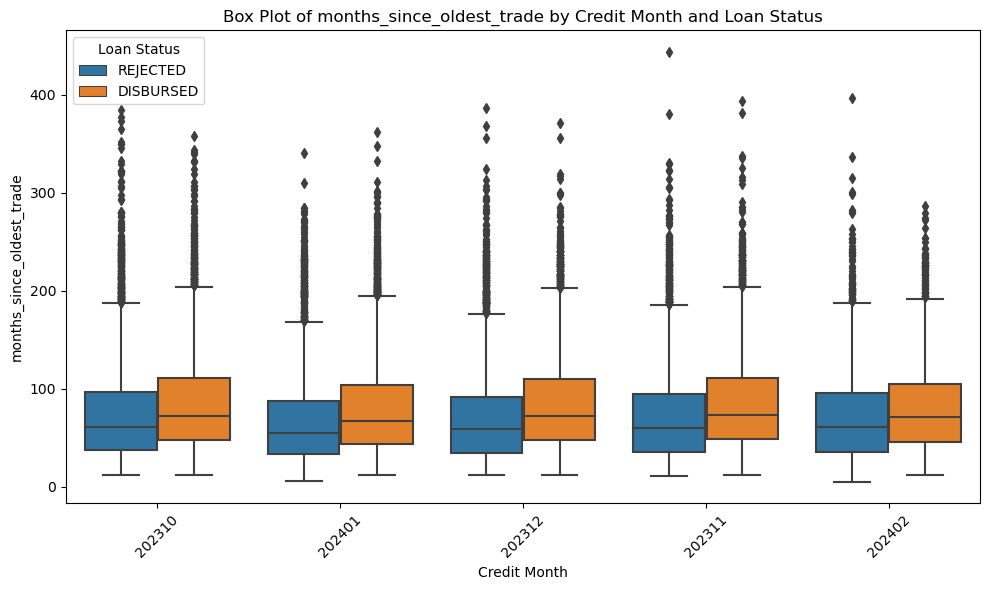

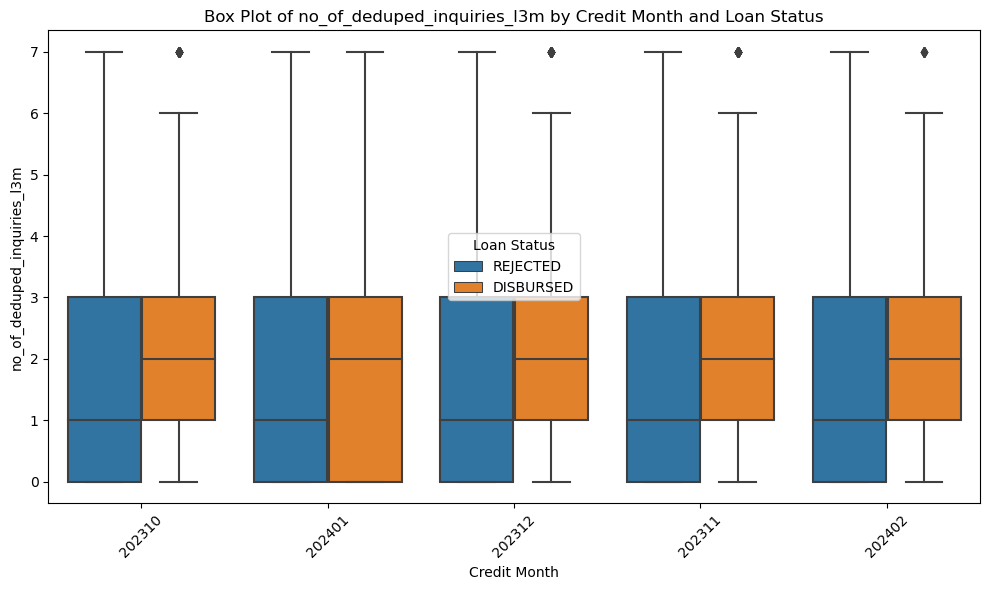

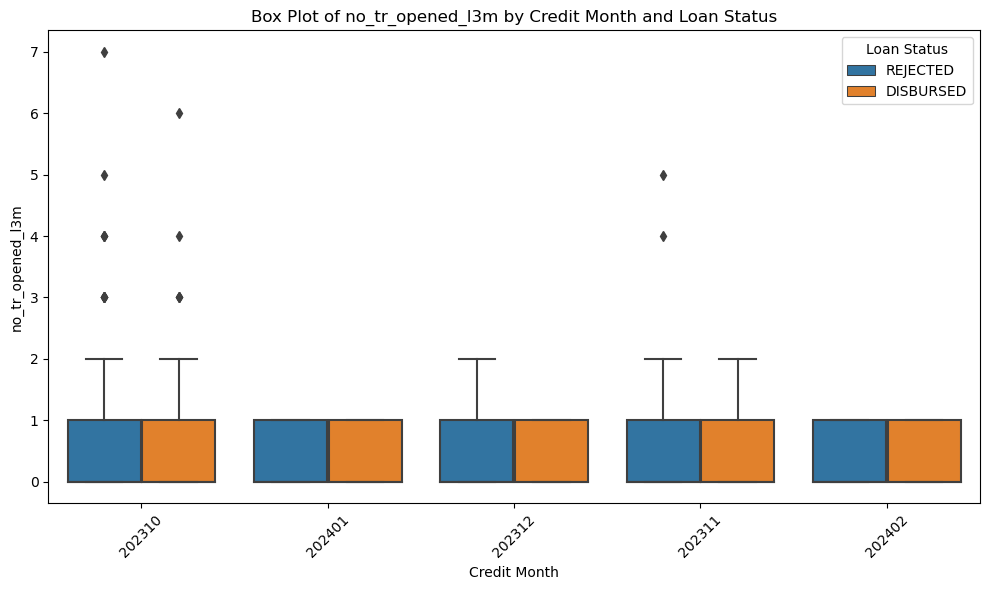

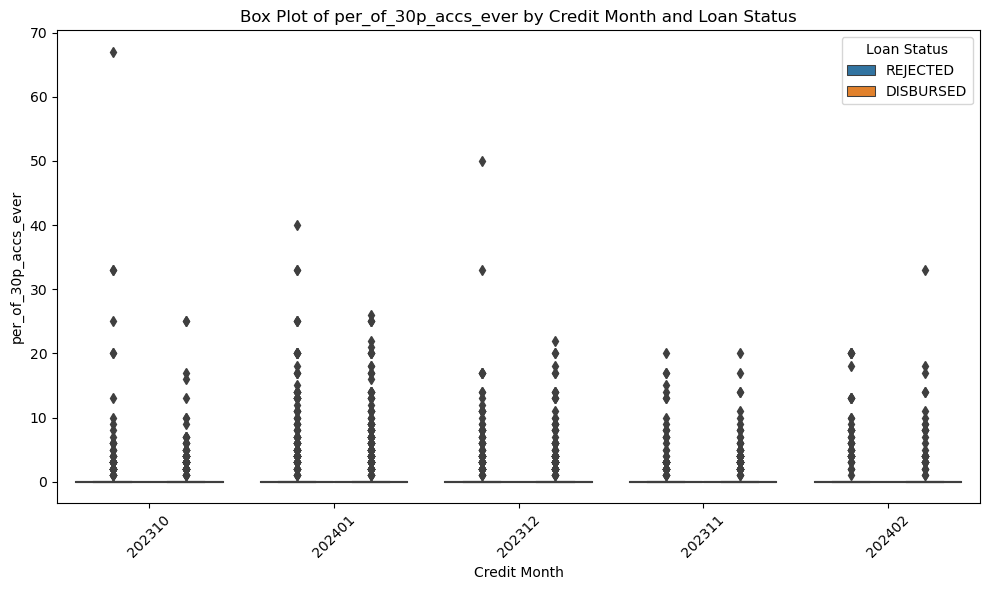

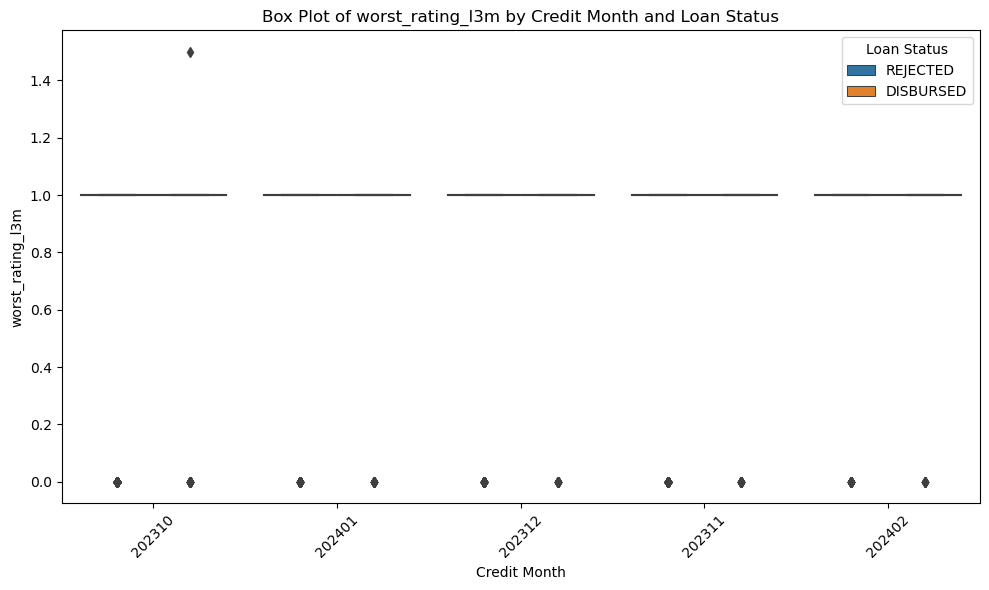

In [22]:
for field in ["bureau_score", "naps_score", "calculated_age", "foir_mean", "months_since_oldest_trade", "no_of_deduped_inquiries_l3m", "no_tr_opened_l3m", "per_of_30p_accs_ever", "worst_rating_l3m"]:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    sns.boxplot(data=df_data, x="credit_month", y=field, hue="loan_status")
    plt.title(f"Box Plot of {field} by Credit Month and Loan Status")
    plt.xlabel("Credit Month")
    plt.ylabel(field)
    plt.legend(title="Loan Status")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [23]:
import pandas as pd

# Assuming df_data is your DataFrame
for column in df_data.columns:
    if pd.api.types.is_datetime64_any_dtype(df_data[column]):
        if df_data[column].dt.tz is not None:
            print(f"Column '{column}' contains datetime values with timezone information.")


Column 'credit_date' contains datetime values with timezone information.


In [24]:
df_data['credit_date'] = pd.to_datetime(df_data['credit_date']).dt.date

In [25]:
df_data.to_excel('rej_analysis_data2.xlsx', index=False)